## Country-level INFRA-SAP

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

In [138]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np
from shapely.geometry import Point

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [2]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

In [3]:
country = 'costarica'
iso3 = 'CRI'
epsg = 32616

### Load origins and graph

In [4]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")
G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

Convert **WP_2020_1km.tif** into a point GeoData frame

In [5]:
inDs = gdal.Open(wp_1km)
out_pop = os.path.join(out_folder, f"{pop_name}.xyz")
outDs = gdal.Translate(out_pop, inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
out_pop_csv = os.path.join(out_folder, f"{pop_name}.csv")
os.rename(out_pop, out_pop_csv)

In [6]:
wp_df = pd.read_csv(out_pop_csv, sep=' ')
wp_df.rename(columns={"Z":"Pop"}, inplace=True)
wp_df = wp_df.loc[wp_df.Pop!=-99999.0].copy()
geoms = [Point(xy) for xy in zip(wp_df.X, wp_df.Y)]
wp_df.drop(["X","Y"], axis=1, inplace=True)
crs = 'EPSG:4326'
origins = gpd.GeoDataFrame(wp_df, crs=crs, geometry=geoms)
origins['pointid'] = origins.index

### Prepare Graph

In [8]:
G = nx.read_gpickle(G_path)

In [9]:
for u, v, data in G.edges(data = True):
    if type(data['Wkt']) == list:
        data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

In [35]:
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
attr_list

['id', 'infra_type', 'osm_id', 'key', 'Type']

#### Salt Network

In [36]:
%%time
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target=f'EPSG:{epsg}', thresh=5000, factor=1000, attr_list=attr_list)

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

Identified 630 unique edge(s) longer than 5000. 
Beginning new node creation...
4456 new edges added and 1262 removed to bring total edges to 8214
1598 new nodes added to bring total nodes to 3233
CPU times: user 1min 33s, sys: 2.94 s, total: 1min 36s
Wall time: 1min 36s


In [37]:
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)

In [39]:
if not os.path.exists(os.path.join(out_folder, 'graph')):
    os.mkdir(os.path.join(out_folder, 'graph'))
gn.save(G_time, f"G_{iso3}_Salt", os.path.join(out_folder, 'graph'))

#### Select largest graph

In [40]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]

In [41]:
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [53]:
inCities = gpd.read_file(urban_extents)
pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

In [58]:
dest_airports = gpd.read_file(airports)
dest_airports = dest_airports.assign(dest_type = 'airport')

In [62]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [63]:
dest_all = pd.concat([dest_cities, dest_ports, dest_airports, dest_borders], ignore_index=True)

In [64]:
dest_all.dest_type.value_counts()

airport    8
border     8
city       4
port       2
Name: dest_type, dtype: int64

In [69]:
dest_all.to_csv(os.path.join(out_folder, 'destination_all.csv'))

In [72]:
len(origins), len(dest_all)

(62322, 22)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [73]:
utm = f"EPSG:{epsg}"

In [81]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 9.77 s, sys: 106 ms, total: 9.87 s
Wall time: 9.84 s


In [83]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [85]:
dest_nn = list(dest_snapped['NN'])
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']
origins_unique_nn = list(set(list_origins_NN))

In [88]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 232 ms


quick checks

In [94]:
curOD[curOD==999999999]

array([], dtype=float64)

In [95]:
curOD.shape

(2471, 22)

In [96]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [97]:
od_df.head()

,1750,new_obj_1163,4763,new_obj_264,new_obj_1030_599_2116,1750,new_obj_1754_541_1904,new_obj_481_119_411,5267_50_148,new_obj_1139,...,new_obj_1805_627_2200,new_obj_311,6805,6805,6805,6805,new_obj_1867,new_obj_1867,new_obj_1867,new_obj_1867
8195,14919.097619,7031.790901,646.894900,13143.174788,6218.996527,14919.097619,18864.084112,18256.647530,33809.191115,355.316983,...,21617.634365,12915.993854,30335.109412,30335.109412,30335.109412,30335.109412,24447.276760,24447.276760,24447.276760,24447.276760
8196,1850.365506,22600.382546,15736.080549,24548.053203,21787.588173,1850.365506,34432.675757,33825.239175,45790.792542,16051.687280,...,33403.430913,26602.917677,31548.806026,31548.806026,31548.806026,31548.806026,35498.883308,35498.883308,35498.883308,35498.883308
new_obj_964,13664.783404,7760.757936,915.133509,11990.474002,6947.963563,13664.783404,19593.051148,18985.614566,32656.490328,1350.266652,...,22346.601400,11763.293068,29182.408625,29182.408625,29182.408625,29182.408625,25176.243796,25176.243796,25176.243796,25176.243796
new_obj_1292_427_1510,18801.035643,4675.052572,4583.472098,17003.725187,5426.311117,18801.035643,16535.169724,16541.339333,34321.519042,3959.953528,...,19288.719977,13428.321781,30847.437339,30847.437339,30847.437339,30847.437339,22118.362372,22118.362372,22118.362372,22118.362372
2393_36_116,16231.866921,8547.260624,2643.318270,14857.136722,7734.466251,16231.866921,20379.553835,19772.117253,35523.153048,2031.343785,...,23133.104088,14629.955788,32049.071345,32049.071345,32049.071345,32049.071345,25962.746483,25962.746483,25962.746483,25962.746483


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [98]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 3.12 s, sys: 6.96 ms, total: 3.13 s
Wall time: 3.13 s


In [99]:
closest_dest = closest_dest.set_index('pointid')

In [100]:
closest_dest.head()

,Pop,geometry,idx,idx_dist
pointid,,,,
177,265.947540,POINT (651070.347 1239876.698),21,605.393660
178,197.396774,POINT (651980.301 1239880.985),21,1128.859165
179,33.114670,POINT (652890.259 1239885.298),21,1959.147076
180,15.100848,POINT (653800.219 1239889.637),21,2838.718257
181,8.140772,POINT (654710.182 1239894.001),21,3732.898671


In [102]:
%%time
fastest_nn = []
fastest_dist = []
custom_speed = 30 # km/h

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 43.7 s, sys: 5.53 ms, total: 43.7 s
Wall time: 43.7 s


In [107]:
origins_snapped = origins.copy().set_index('pointid')
origins_snapped['NN'] = pd.Series(fastest_nn, index = origins_snapped.index)
origins_snapped['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped.index)
origins_snapped['pointid'] = origins_snapped.index
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

In [114]:
origins_snapped.head()

,Pop,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours
pointid,,,,,,,
177,265.947540,POINT (-85.61625 11.21292),new_obj_1867,670.166343,177,80.419961,0.022339
178,197.396774,POINT (-85.60792 11.21292),new_obj_1867,761.241509,178,91.348981,0.025375
179,33.114670,POINT (-85.59958 11.21292),new_obj_1867,1538.168266,179,184.580192,0.051272
180,15.100848,POINT (-85.59125 11.21292),new_obj_1867,2410.095218,180,289.211426,0.080337
181,8.140772,POINT (-85.58292 11.21292),new_obj_1867,3302.619854,181,396.314382,0.110087


In [117]:
origins_join = origins_snapped.join(od_df, on='NN')

In [ ]:
all(origins_join.columns[6:] == dest_snapped.NN)

In [123]:
origins_join_rename = origins_join.copy()
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [129]:
origins_join_rename.head()

origin                                                         \
                Pop                    geometry            NN      NN_dist   
pointid                                                                      
177      265.947540  POINT (-85.61625 11.21292)  new_obj_1867   670.166343   
178      197.396774  POINT (-85.60792 11.21292)  new_obj_1867   761.241509   
179       33.114670  POINT (-85.59958 11.21292)  new_obj_1867  1538.168266   
180       15.100848  POINT (-85.59125 11.21292)  new_obj_1867  2410.095218   
181        8.140772  POINT (-85.58292 11.21292)  new_obj_1867  3302.619854   

                                                       city                \
        pointid NN_dist_seconds NN_dist_hours             0             1   
pointid                                                                     
177         177       80.419961      0.022339  34276.127171  17435.448552   
178         178       91.348981      0.025375  34276.127171  17435.448552   
179         179      184.580192      0.051272  34276.127171  17435.448552   
180         180      289.211426      0.080337  34276.127171  17435.448552   
181         181      396.314382      0.110087  34276.127171  17435.448552   

                       ...      airport                     border  \
                    2  ...           12            13           14   
pointid                ...                                           
177      24699.370453  ...  6429.162396  29171.851913  46590.96747   
178      24699.370453  ...  6429.162396  29171.851913  46590.96747   
179      24699.370453  ...  6429.162396  29171.851913  46590.96747   
180      24699.370453  ...  6429.162396  29171.851913  46590.96747   
181      24699.370453  ...  6429.162396  29171.851913  46590.96747   

                                                                    
                  15           16           17   18   19   20   21  
pointid                                                             
177      46590.96747  46590.96747  46590.96747  0.0  0.0  0.0  0.0  
178      46590.96747  46590.96747  46590.96747  0.0  0.0  0.0  0.0  
179      46590.96747  46590.96747  46590.96747  0.0  0.0  0.0  0.0  
180      46590.96747  46590.96747  46590.96747  0.0  0.0  0.0  0.0  
181      46590.96747  46590.96747  46590.96747  0.0  0.0  0.0  0.0  

[5 rows x 29 columns]

Add snapping time to each column (speed of 30 km/h)

In [130]:
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [131]:
origins_join2.head()

origin                                                         \
                Pop                    geometry            NN      NN_dist   
pointid                                                                      
177      265.947540  POINT (-85.61625 11.21292)  new_obj_1867   670.166343   
178      197.396774  POINT (-85.60792 11.21292)  new_obj_1867   761.241509   
179       33.114670  POINT (-85.59958 11.21292)  new_obj_1867  1538.168266   
180       15.100848  POINT (-85.59125 11.21292)  new_obj_1867  2410.095218   
181        8.140772  POINT (-85.58292 11.21292)  new_obj_1867  3302.619854   

                                                       city                \
        pointid NN_dist_seconds NN_dist_hours             0             1   
pointid                                                                     
177         177       80.419961      0.022339  34356.547132  17515.868513   
178         178       91.348981      0.025375  34367.476152  17526.797533   
179         179      184.580192      0.051272  34460.707363  17620.028744   
180         180      289.211426      0.080337  34565.338597  17724.659978   
181         181      396.314382      0.110087  34672.441553  17831.762935   

                       ...      airport                      border  \
                    2  ...           12            13            14   
pointid                ...                                            
177      24779.790414  ...  6509.582357  29252.271874  46671.387431   
178      24790.719434  ...  6520.511377  29263.200894  46682.316451   
179      24883.950645  ...  6613.742587  29356.432105  46775.547662   
180      24988.581880  ...  6718.373822  29461.063339  46880.178896   
181      25095.684836  ...  6825.476778  29568.166295  46987.281852   

                                                                           \
                   15            16            17          18          19   
pointid                                                                     
177      46671.387431  46671.387431  46671.387431   80.419961   80.419961   
178      46682.316451  46682.316451  46682.316451   91.348981   91.348981   
179      46775.547662  46775.547662  46775.547662  184.580192  184.580192   
180      46880.178896  46880.178896  46880.178896  289.211426  289.211426   
181      46987.281852  46987.281852  46987.281852  396.314382  396.314382   

                                 
                 20          21  
pointid                          
177       80.419961   80.419961  
178       91.348981   91.348981  
179      184.580192  184.580192  
180      289.211426  289.211426  
181      396.314382  396.314382  

[5 rows x 29 columns]

In [133]:
out_folder

'/home/wb514197/data/INFRA_SAP/CRI'

In [134]:
origins_join2.to_csv(os.path.join(out_folder, 'OD_08_03.csv'))

In [135]:
od_cities = np.array(origins_join2['city'])

### Calculate gravity

In [136]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 1min 14s, sys: 447 ms, total: 1min 15s
Wall time: 1min 14s


In [160]:
access_cities.index = origins_join2.index

In [161]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

#### Convert to raster and save results

In [162]:
raster_path = wp_1km

In [163]:
output_path = os.path.join(out_folder, "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

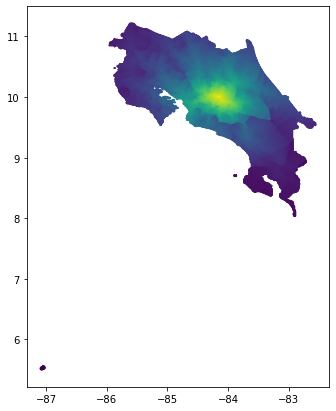

In [164]:
access_cities_results.plot(column='d_7', figsize=(7,7), markersize=1)

In [165]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8
writing 9


### Make rasters of min travel time to each dest

In [166]:
output_path = os.path.join(out_folder, "travel_time")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [191]:
# CHECK THAT MOST POPULATED CITY IS THE CAPITAL
cap_idx = dest_all.sort_values('Pop', ascending=False).iloc[[0]].index[0]

In [192]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_border"])
capital_tt = origins_join2['city'].loc[:,[cap_idx]].apply(lambda x: (x/3600)).rename(columns={cap_idx:'tt_capital'})

In [193]:
origins_tt = origins_snapped.join([city_min, ports_min, airports_min, borders_min, capital_tt])

In [196]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_tt.tif"))